# `MultiModel` framework

Here we showcase the `MultiModel` framework, a standalone framework within `neurolib` to create and simulate heterogeneous brain models. By heterogeneous, we mean that a brain network may consist of nodes with totally different dynamics coupled by a single variable. Imagine having a population model for the thalamus, a different model for the hippocampus, and a different model for the cortex. Of course, the parameters and the model dynamics, and the equations would be completely different. This is all possible and even relatively easy in `MultiModel`.

## Implemented models
To facilitate your heterogeneous experiments, the `MultiModel` comes with few population models predefined for you. We can mix these into a brain network in many ways. We provide:

* `aln`: the adaptive linear-nonlinear population model, it is a mean-field approximation of delay-coupled network of excitatory and inhibitory adaptive exponential integrate-and-fire neurons (AdEx)
* `fitzhugh_nagumo`: the FitzHugh-Nagumo model, a two-dimensional slow-fast system, is a simplified version of the famous 4D Hodgkin–Huxley model
* `hopf`: the Hopf model (sometimes called a Stuart-Landau oscillator) is a 1D nonlinear model and serves as a normal form of Hopf bifurcation in dynamical systems
* `thalamus`: a conductance-based population rate model of the thalamus, it is a Jansen-Rit like population model with current-based voltage evolution, includes adaptation (*K*-leak), calcium, and rectifying currents
* `wilson_cowan`: the Wilson-Cowan neuronal model is a simple model of interacting interconnected neurons of excitatory and inhibitory subtypes
* `wong_wang`: a Wong-Wang model, a model approximating a biophysically-based cortical network model. Our implementation comes in two flavors:
    * original Wong-Wang model with excitatory and inhibitory subtypes
    * reduced Wong-Wang model with simpler dynamics and no EXC/INH distinction
    
Moreover, the `MultiModel` framework is built in such a way that creating and connecting new models (e.g., Jansen-Rit) is easy and intuitive. An example of how to make a brand new model implementation in `MultiModel` is provided in the following example notebook (`example-4.1-create-new-model.ipynb`).

## Modeling hierarchy
The `MultiModel` relies on the modeling hierarchy, which is typically implicit in whole-brain modeling. This hierarchy has three levels:
* `NeuralMass`: represents a single neural population (typically excitatory, inhibitory, or without a subtype) and is defined by a set of parameters and (possibly delayed) (possibly stochastic) differential equations
* `Node`: represents a single brain node, and it is a set of connected neural masses (so, e.g., a single Wilson-Cowan node consists of one excitatory and one inhibitory Wilson-Cowan `NeuralMass`)
* `Network`: represents a brain network, and it is a set of connected nodes (can be any type, as long as the coupling variables are the same)

Although the magic happens at the level of `NeuralMass` (by magic, we mean the dynamics), users can only simulate (integrate) a `Node` or a `Network`. In other words, even for models without excitatory/inhibitory subtyping (e.g., Hopf or FitzHugh-Nagumo), we create a `Node` consisting of one `NeuralMass`. In the case of, e.g., Wilson-Cowan, ALN, or original Wong-Wang model, the `Node` consists of one excitatory and one inhibitory mass. More info on the modeling hierarchy and how it actually works is provided in the following example notebook (`example-4.1-create-new-model.ipynb`), where we need to subclass the base classes for this hierarchy to build a new model.

## Basic usage in `neurolib`
(In the following we expect the reader to be mildly familiar with how `neurolib` works, e.g. how to run a model, how to change it parameters, and how to get model results)

In [8]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')

# import stuff

# try:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import neurolib.utils.functions as func
from neurolib.utils.stimulus import OrnsteinUhlenbeckProcess


from neurolib.models.multimodel import WilsonCowanNetwork, WilsonCowanNode, MultiModel

# except ImportError:
#     import sys
#     !{sys.executable} -m pip install matplotlib
#     import matplotlib.pyplot as plt

In [9]:
from neurolib.utils.loadData import Dataset

ds = Dataset("gw", fcd = True)

In [10]:
def loadMat():
    Cmatrix = []
    Dmatrix = []
    Fmatrix = []
    Tmatrix = []
    FC_LR = []
    FC_RL = []
    TC_LR = []
    TC_RL = []

    dataDir = "/Users/pamirozsuna/Desktop/Masterarbeit/pamir_master_thesis/"

    subjectsFC = sorted(glob.glob(dataDir + "FC/1_AAL/*")) # reading the file names using glob
    subjectsSC = sorted(glob.glob(dataDir + "SC/1_AAL/*"))
    for subjectSC in subjectsSC:
	    for subjectFC in subjectsFC:
	    	# take subjects only if they have all SC, LR_FC and RL_FC matrices
	    	if(subjectSC[-6:]==subjectFC[-6:] and os.path.isfile(subjectFC + '/rfMRI_REST1_LR/FC.mat')  and os.path.isfile(subjectFC + '/rfMRI_REST1_RL/FC.mat')):
	    		this_cm = loadmat(subjectSC + "/DTI_CM.mat")['SC']
	    		Cmatrix.append(this_cm)
	    		this_dc = loadmat(subjectSC + "/DTI_LEN.mat")['LEN']
	    		Dmatrix.append(this_dc)
	    		FC_LR = loadmat(subjectFC + '/rfMRI_REST1_LR/FC.mat')["fc"]
	    		TC_LR = loadmat(subjectFC + '/rfMRI_REST1_LR/TC.mat')["tc"]
	    		FC_RL = loadmat(subjectFC + '/rfMRI_REST1_RL/FC.mat')["fc"]
	    		TC_RL = loadmat(subjectFC + '/rfMRI_REST1_RL/TC.mat')["tc"]
	    		Fmatrix.append(filterSubcortical(np.mean( np.array([FC_LR, FC_RL]), axis=0)))
	    		Tmatrix.append(filterSubcortical(np.mean( np.array([TC_LR[:,0:355], TC_RL[:,0:355]]), axis=0), axis=0))
        
    return Cmatrix,Dmatrix,Tmatrix,Fmatrix

In [11]:
def averageMat(Mat):
    avMat = np.zeros((94,94))
    for i in range(len(Mat)):
        avMat = avMat + Mat[i]
    avMat = avMat/len(Mat)
    return avMat

def ComputeAverageMats(Cmatrix, Dmatrix):
    Cmat = averageMat(Cmatrix)
    Dmat = averageMat(Dmatrix)
    return Cmat, Dmat


In [12]:
import glob
from scipy.io import loadmat
from neurolib.utils.loadData import filterSubcortical

ds = Dataset(datasetName = 'gw', normalizeCmats = None)
dataDict_sc, dataDict_len, dataDict_ts, dataDict_fc = loadMat()

GW_FC_mean = np.mean(ds.FCs, axis=0) # Average FC GW
ds.FCs = []
ds.FCs.append(GW_FC_mean)
ds.FCs.append(np.mean(dataDict_fc, axis=0)) # Add average FC HCP
print("ds FCs shape: " + str(np.shape(ds.FCs)))

print(np.shape(dataDict_ts))
GW_BOLD_mean = np.mean(ds.BOLDs, axis = 0)
print(np.shape(GW_BOLD_mean))
ds.BOLDs = []
ds.BOLDs.append(GW_BOLD_mean)
ds.BOLDs.append(np.mean(dataDict_ts, axis=0))
print("ds BOLDs length: " + str(len(ds.BOLDs)))

ds.Cmat, ds.Dmat = ComputeAverageMats(dataDict_sc, dataDict_len)
ds.Cmat = filterSubcortical(ds.Cmat)
ds.Cmats = dataDict_sc
ds.data = []
ds.Dmat = filterSubcortical(ds.Dmat)
ds.Dmats = dataDict_len
ds.dsBaseDirectory = '../Data/'

ds FCs shape: (2, 80, 80)
(143, 80, 355)
(80, 355)
ds BOLDs length: 2


In [13]:
#dummy_sc = np.array([[0.0, 1.0], [1.0, 0.0]])
# init MultiModelnetwork with 2 WC nodes with dummy sc and no delays
K_gl = 1.84
connectivity_matrix_data = ds.Cmat*K_gl
delay_matrix_data = ds.Dmat


#mm_net = WilsonCowanNetwork(connectivity_matrix=connectivity_matrix_data, delay_matrix=delay_matrix_data, exc_mass_params = dict_exc, inh_mass_params = dict_inh)
mm_net = WilsonCowanNetwork(connectivity_matrix=connectivity_matrix_data, delay_matrix=delay_matrix_data, local_connectivity =  np.array([[16.0, 9.67], [10.33, 0]]))
#print(mm_net)
# each network is an proper python iterator, i.e. len() is defined

In [14]:
# now let us check the parameters.. for this we initialise MultiModel in neurolib's fashion
#aln_net = MultiModel(mm_net)
wc_net = MultiModel(mm_net)
# parameters are accessible via .params
#aln_net.params
#print(wc_net.params)

wc_net.params["duration"] = 10.0
wc_net.params["backend"] = "numba"
# numba uses Euler scheme so dt is important!
wc_net.params["dt"] = 0.1
wc_net.params["sampling_dt"] = 1.0

#wc_net.params['*EXC*ext_drive'] = 0.45
#wc_net.params['node_exc_inh'] = 10.33
#wc_net.params['node_inh_exc'] = 9.67
#wc_net.params['node_inh_inh'] = 0
#wc_net.params['network_exc_exc'] = 1.843
#wc_net.params['network_inh_exc'] = 1.843

for node in range(len(ds.Cmat)):
    wc_net.params[f"WCnet.WCnode_{node}.WCmassEXC_0.input_0.sigma"] = 0.05
    wc_net.params[f"WCnet.WCnode_{node}.WCmassEXC_0.ext_drive"] = 0.45
    
#wc_net.params['sigma_ou'] = 4.2819e-05
# as you can see the parameters are flattened nested dictionary which follows this nomenclature
# {"<network label>.<node label>_index.<mass label>_index.<param name>: param value"}

In [15]:
wc_net.params

{'WCnet.WCnode_0.WCmassEXC_0.a': 1.5,
 'WCnet.WCnode_0.WCmassEXC_0.mu': 3.0,
 'WCnet.WCnode_0.WCmassEXC_0.tau': 2.5,
 'WCnet.WCnode_0.WCmassEXC_0.ext_drive': 0.45,
 'WCnet.WCnode_0.WCmassEXC_0.input_0.type': 'OrnsteinUhlenbeckProcess',
 'WCnet.WCnode_0.WCmassEXC_0.input_0.mu': 0.0,
 'WCnet.WCnode_0.WCmassEXC_0.input_0.sigma': 0.05,
 'WCnet.WCnode_0.WCmassEXC_0.input_0.tau': 5.0,
 'WCnet.WCnode_0.WCmassEXC_0.input_0.n': 1,
 'WCnet.WCnode_0.WCmassEXC_0.input_0.seed': None,
 'WCnet.WCnode_0.WCmassINH_1.a': 1.5,
 'WCnet.WCnode_0.WCmassINH_1.mu': 3.0,
 'WCnet.WCnode_0.WCmassINH_1.tau': 3.75,
 'WCnet.WCnode_0.WCmassINH_1.ext_drive': 0.0,
 'WCnet.WCnode_0.WCmassINH_1.input_0.type': 'OrnsteinUhlenbeckProcess',
 'WCnet.WCnode_0.WCmassINH_1.input_0.mu': 0.0,
 'WCnet.WCnode_0.WCmassINH_1.input_0.sigma': 0.0,
 'WCnet.WCnode_0.WCmassINH_1.input_0.tau': 5.0,
 'WCnet.WCnode_0.WCmassINH_1.input_0.n': 1,
 'WCnet.WCnode_0.WCmassINH_1.input_0.seed': None,
 'WCnet.WCnode_0.local_connectivity': array([[16.

In [16]:
display(wc_net.model_instance.describe())

{'name': 'Wilson-Cowan network',
 'num_nodes': 80,
 'num_state_variables': 160,
 'num_noise_variables': 160,
 'nodes': [{'index': 0,
   'name': 'Wilson-Cowan node',
   'num_masses': 2,
   'num_num_state_variables': 2,
   'num_noise_variables': 2,
   'masses': [{'index': 0,
     'name': 'Wilson-Cowan excitatory mass',
     'mass_type': 'EXC',
     'num_state_variables': 1,
     'num_noise_variables': 1,
     'state_variable_names': ['q_mean_EXC'],
     'params': {'a': 1.5,
      'mu': 3.0,
      'tau': 2.5,
      'ext_drive': 0.0,
      'input_0': {'type': 'OrnsteinUhlenbeckProcess',
       'mu': 0.0,
       'sigma': 0.0,
       'tau': 5.0,
       'n': 1,
       'seed': None}}},
    {'index': 1,
     'name': 'Wilson-Cowan inhibitory mass',
     'mass_type': 'INH',
     'num_state_variables': 1,
     'num_noise_variables': 1,
     'state_variable_names': ['q_mean_INH'],
     'params': {'a': 1.5,
      'mu': 3.0,
      'tau': 3.75,
      'ext_drive': 0.0,
      'input_0': {'type': 'Ornste

In [17]:
wc_net.run()

/Users/pamirozsuna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  """
/Users/pamirozsuna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  """


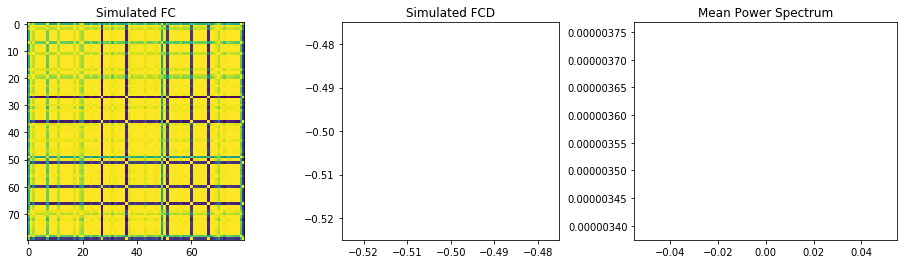

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].set_title("Simulated FC")
axs[0].imshow(func.fc(wc_net.q_mean_EXC[:, -10000:]))
axs[1].set_title("Simulated FCD")
axs[1].imshow(func.fcd(wc_net.q_mean_EXC[:, -10000:], stepsize=100))
axs[2].set_title("Mean Power Spectrum")
fr, pw = func.getMeanPowerSpectrum(wc_net.q_mean_EXC, wc_net.params["dt"])
axs[2].plot(fr, pw, c='k', lw = 2)

In [22]:
#plt.plot(wc_net.t, wc_net.q_mean_EXC.T)

In [23]:
scores = [func.matrix_correlation(func.fc(wc_net.q_mean_EXC[:, -int(5000/wc_net.params['dt']):]), fcemp) for fcemp in ds.FCs]
print("Correlation per subject:", [f"{s:.2}" for s in scores])
print("Mean FC/FC correlation: {:.2f}".format(np.mean(scores)))

Correlation per subject: ['-0.016', '-0.048']
Mean FC/FC correlation: -0.03
